


<h2 align="center">Simplilearn Certification Programs - Deep Learning with Keras and Tensorflow</h2>  

<div style="font-size:20px;">
<br/><b> <center> Project Report - Lending Club Loan Data Analysis</center></b><br/>
</div>

<div  style="font-size: 15px">
Organization: <b>Simplilearn (Certification Program)</b><br>
Course: <b>Deep Learning with Keras and Tensorflow</b><br>
Project: <b>Lending Club Loan Data Analysis</b><br>
Programming Language: <b>Python</b><br>
Submitted by: <b>Lavkush Singh</b>
</div>

## Problem Statement

**In this project, using the historical data from 2007 to 2015, you have to build a deep learning model to predict the chance of default for future loans.**

##### Analysis Tasks to be performed

1. Feature Transformation
        - Transform categorical values into numerical values (discrete)

2. Exploratory data analysis of different factors of the dataset.


3. Additional Feature Engineering
        - You will check the correlation between features and will drop those features which have a strong correlation
        - This will help reduce the number of features and will leave you with the most relevant features

4. Modeling
        - After applying EDA and feature engineering, you are now ready to build the predictive models
        - In this part, you will create a deep learning model using Keras with Tensorflow backend

In [1]:
# importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from plot_metric.functions import BinaryClassification

In [2]:
# setting options to display for jupyter notebook
pd.options.display.max_rows = None

### Task: Load the dataset 

In [3]:
data_main = pd.read_csv(r"Datasets\loan_data.csv", low_memory = False)

In [4]:
df = data_main.copy(deep = True) # creating the copy to keep the original data intact

#### Exploring the dataset

In [5]:
df.head() 

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [6]:
df.info(verbose = True, show_counts=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [7]:
df['not.fully.paid'].isnull().any() # checking if the 'not.fully.paid' (target) column has null values

False

In [8]:
df['not.fully.paid'].value_counts()

0    8045
1    1533
Name: not.fully.paid, dtype: int64

<div style="font-size: 16px;color:blue"> <b>Analysis Summary: </b></div><br/>

<div  style="font-size:15px;color:blue">
- The dataset contains total 14 columns (including target) with 9578 observations.<br/>
- This is a supervised binary (0,1) classification problem.<br/>
- The dataset is imbalanced, with more of '0' class.<br/>
</div>

### Task: Validation and Handling of the NULL and Duplicate Values

In [9]:
# custom function which takes dataframe as input and returns a dataframe of null values column wise, along with percentage

def create_nulls_df(dataframe):
    nulls_count = dataframe.isna().sum()[dataframe.isnull().sum() > 0]
    nulls_info_df = pd.DataFrame({'column':nulls_count.index, 
                                  'null_values': nulls_count.values}).sort_values(by=['null_values'])
    nulls_info_df['nulls_percent'] = ((nulls_info_df['null_values']/df.shape[0])*100).round(2)

    return nulls_info_df

In [10]:
nulls_info_df = create_nulls_df(dataframe=df)
nulls_info_df

,column,null_values,nulls_percent


In [11]:
df.duplicated().sum()

0

#### Data Exploration

In [12]:
# custom function which takes dataframe as input and returns the unique values in each column, along with count in dict format

def unique_value_and_counts(dataframe):
    result = dict()
    for col in dataframe.columns:
        unique_counts = ('UNIQUE_COUNTS', dataframe[col].nunique())
        value = list(zip(dataframe[col].value_counts().index, dataframe[col].value_counts()))
        value.insert(0, unique_counts)
        result[col] = value
    return result     

In [13]:
df.columns

Index(['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc',
       'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid'],
      dtype='object')

In [14]:
# getting the unique values in each column along with the count 
# (dataframe passed here is having column values as discrete)

temp = unique_value_and_counts(df[['purpose','credit.policy','inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid']])
temp

{'purpose': [('UNIQUE_COUNTS', 7),
  ('debt_consolidation', 3957),
  ('all_other', 2331),
  ('credit_card', 1262),
  ('home_improvement', 629),
  ('small_business', 619),
  ('major_purchase', 437),
  ('educational', 343)],
 'credit.policy': [('UNIQUE_COUNTS', 2), (1, 7710), (0, 1868)],
 'inq.last.6mths': [('UNIQUE_COUNTS', 28),
  (0, 3637),
  (1, 2462),
  (2, 1384),
  (3, 864),
  (4, 475),
  (5, 278),
  (6, 165),
  (7, 100),
  (8, 72),
  (9, 47),
  (10, 23),
  (11, 15),
  (12, 15),
  (15, 9),
  (13, 6),
  (14, 6),
  (18, 4),
  (16, 3),
  (19, 2),
  (24, 2),
  (17, 2),
  (33, 1),
  (20, 1),
  (27, 1),
  (25, 1),
  (28, 1),
  (31, 1),
  (32, 1)],
 'delinq.2yrs': [('UNIQUE_COUNTS', 11),
  (0, 8458),
  (1, 832),
  (2, 192),
  (3, 65),
  (4, 19),
  (5, 6),
  (6, 2),
  (13, 1),
  (7, 1),
  (8, 1),
  (11, 1)],
 'pub.rec': [('UNIQUE_COUNTS', 6),
  (0, 9019),
  (1, 533),
  (2, 19),
  (3, 5),
  (4, 1),
  (5, 1)],
 'not.fully.paid': [('UNIQUE_COUNTS', 2), (0, 8045), (1, 1533)]}

In [15]:
temp['purpose']

[('UNIQUE_COUNTS', 7),
 ('debt_consolidation', 3957),
 ('all_other', 2331),
 ('credit_card', 1262),
 ('home_improvement', 629),
 ('small_business', 619),
 ('major_purchase', 437),
 ('educational', 343)]

In [16]:
purpose_index = [tup[0] for tup in temp['purpose'][1:]]
print(purpose_index)

['debt_consolidation', 'all_other', 'credit_card', 'home_improvement', 'small_business', 'major_purchase', 'educational']


In [17]:
purpose_values = [tup[1] for tup in temp['purpose'][1:]]
print(purpose_values)

[3957, 2331, 1262, 629, 619, 437, 343]


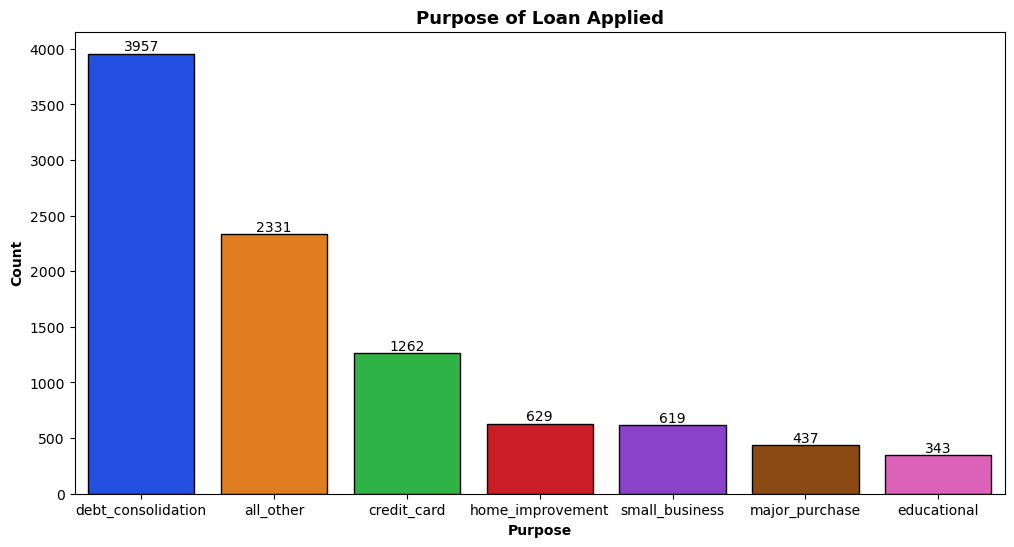

In [18]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x = purpose_index, y = purpose_values, palette = "bright", edgecolor='black')
ax.bar_label(ax.containers[0])
plt.title('Purpose of Loan Applied', fontsize = 13, fontweight="bold")
plt.xlabel('Purpose', fontweight="bold")
plt.ylabel('Count', fontweight="bold");

In [19]:
df_encoded = pd.get_dummies(df, drop_first = True)
df_encoded.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


In [20]:
df_encoded.shape

(9578, 19)

In [21]:
credit_policy_status = df['credit.policy'].value_counts()
credit_policy_status

1    7710
0    1868
Name: credit.policy, dtype: int64

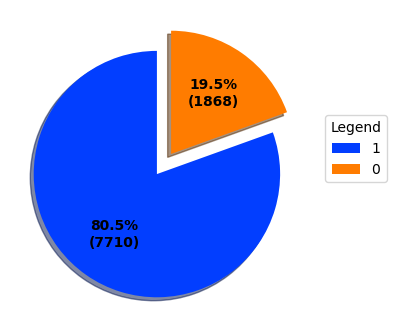

In [22]:
fig, ax = plt.subplots(figsize=[12,4])

labels = credit_policy_status.index
data = credit_policy_status.values
title = "Credit Status Distribution"
colors = sns.color_palette('bright')[0:10]


def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute})"

wedges, texts, autopcts = ax.pie(x= data, 
                                 autopct=lambda pct: func(pct, data), 
                                 explode=[0.1]*len(data), 
                                 shadow=True, 
                                 startangle = 90,
                                 colors = colors,
                                 radius=1
                                 )
# Adding legend
ax.legend(wedges, labels,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0.5, 1, 0.1))

plt.setp(autopcts, **{'color':'black', 'weight':'bold', 'fontsize':10});

In [23]:
set_1 = ['int.rate', 'installment', 'log.annual.inc', 'dti']
set_2 = ['fico', 'days.with.cr.line', 'revol.bal', 'revol.util']

In [24]:
# converting columns into array to traverse through it and plotting graph as sub-plots

arr_cols = np.array(set_1).reshape(2,2)
arr_cols

array([['int.rate', 'installment'],
       ['log.annual.inc', 'dti']], dtype='<U14')

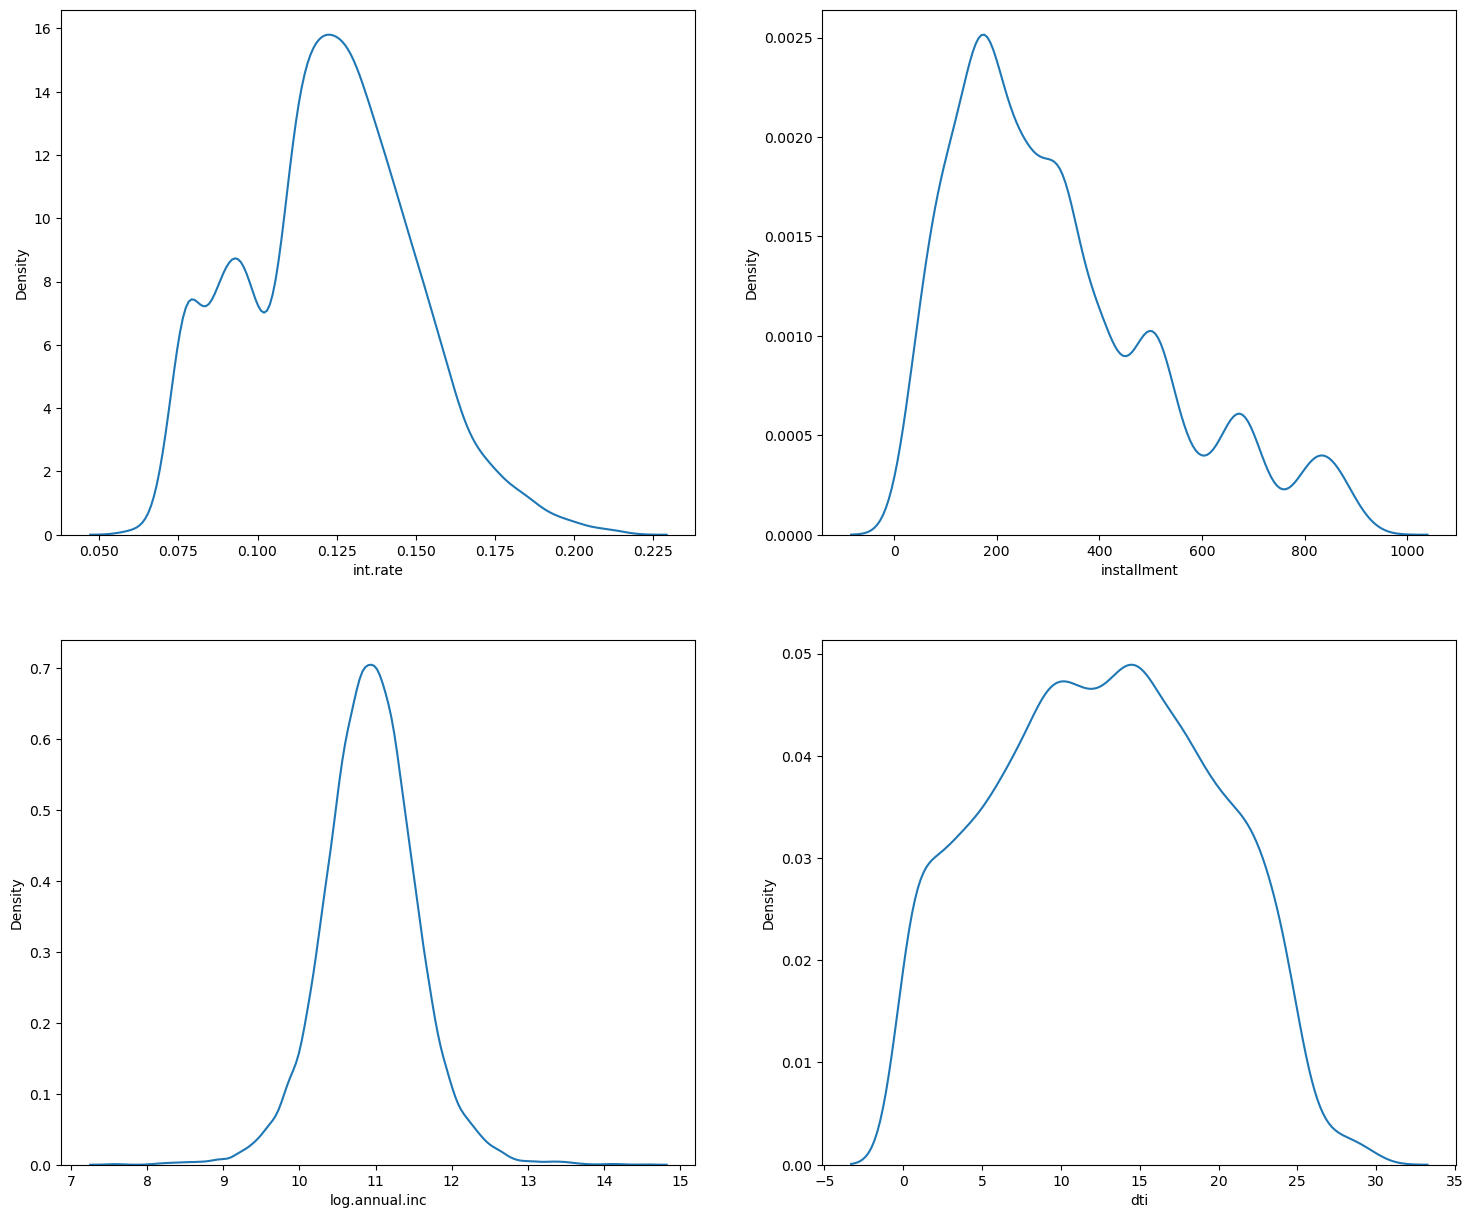

In [25]:
# plotting KDE plot to view how the data is distributed

fig, axes = plt.subplots(2, 2, figsize=(18, 15))

for i in range(2):
    for j in range(2):
            sns.kdeplot(ax=axes[i, j], data = df, x = arr_cols[i,j])

In [26]:
# converting second set of columns into array to traverse through it and plotting graph as sub-plots

arr_cols = np.array(set_2).reshape(2,2)
arr_cols

array([['fico', 'days.with.cr.line'],
       ['revol.bal', 'revol.util']], dtype='<U17')

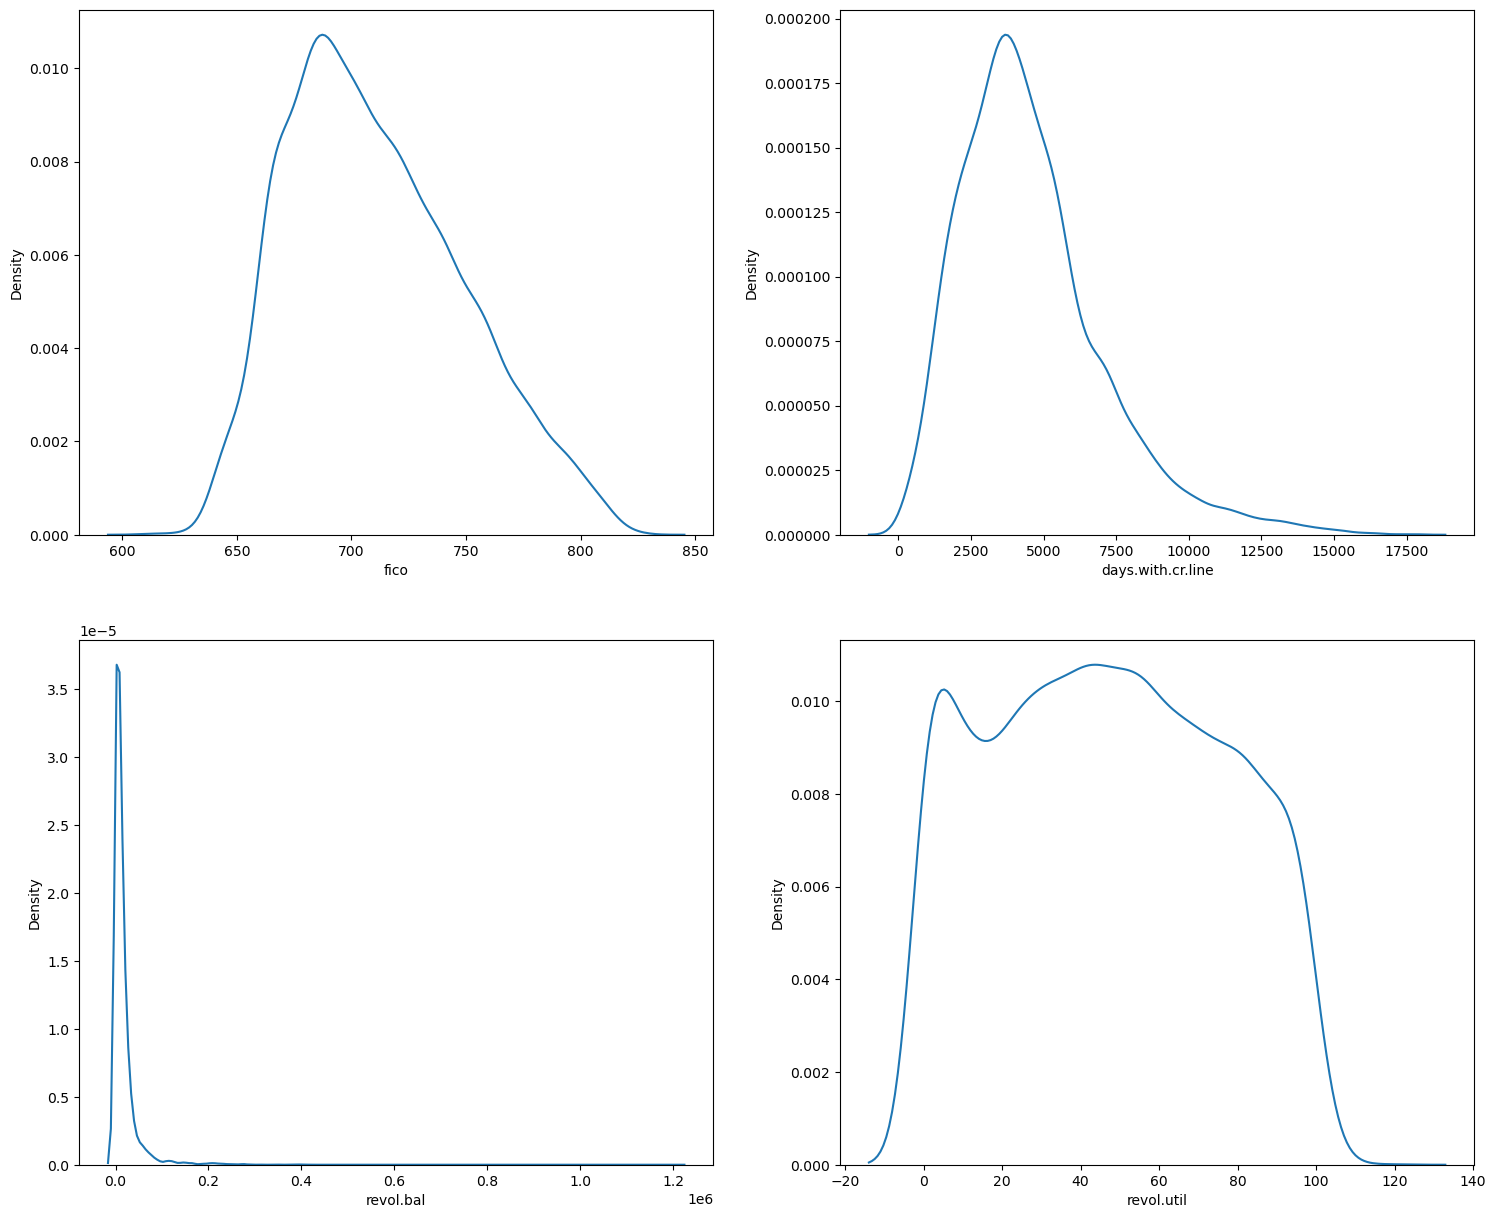

In [27]:
# plotting KDE plot to view how the data is distributed

fig, axes = plt.subplots(2, 2, figsize=(18, 15))

for i in range(2):
    for j in range(2):
            sns.kdeplot(ax=axes[i, j], data = df, x = arr_cols[i,j])

<div style="font-size: 16px;color:blue"> <b>Analysis Summary: </b></div><br/>
<div  style="font-size:15px;color:blue">
- The dataset contains 67 columns with null values, where 49 columns has more than 40% datapoints missing.<br/>
- When all the rows having null values (even a single null value) was dropped, it was observed that about 97.2% of the observations were lost.<br/>
- The resultant dataset was having 8602 rows and 121 columns.<br/>
- Therefore, imputation was appropriate method to deal with the missing values to avoid data loss.<br/>
- All the blank rows were removed, of the columns having more than 40% missing values.<br/>
- Then, 'mode' was imputed to the categorical columns. This was applied to those columns also, whose datatype was numerical but the values were discrete.<br/>
- The continuous numerical data type columns were imputed with 'median'<br/>
</div>




### Task: Print percentage of default to payer of the dataset for the TARGET column

In [28]:
target_dist = df["not.fully.paid"].value_counts()
target_dist

0    8045
1    1533
Name: not.fully.paid, dtype: int64

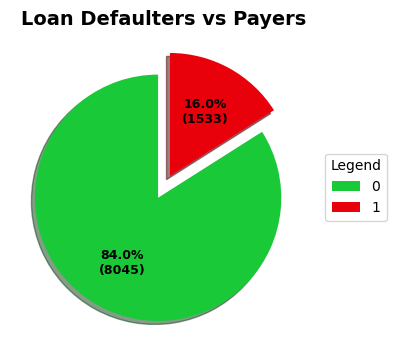

In [29]:
fig, ax = plt.subplots(figsize=[12,4])

labels = target_dist.index
data = target_dist.values
title = "Loan Defaulters vs Payers"
colors = sns.color_palette('bright')[2:4]


def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

wedges, texts, autopcts = ax.pie(x= data, 
                                 autopct=lambda pct: func(pct, data), 
                                 explode=[0.1]*len(data), 
                                 shadow=True, 
                                 startangle = 90,
                                 colors = colors
                                 )
# Adding legend
ax.legend(wedges, labels,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autopcts, **{'color':'black', 'weight':'bold', 'fontsize':9})
plt.title(title, fontsize=14, fontweight="bold");


#### Correlation Analysis

In [30]:
# This below function calculates the Variance Inflation Factor, which basically tells us if the numerical column present in 
# our data is adding to the value or not.

def get_VIF(input_df):
    
    cols = input_df.columns
    
    for col in cols:
        X = input_df.drop(col, axis = 1)
        y = input_df[col]
        
        r_sq = ols(formula = 'y ~ X', data = input_df).fit().rsquared
        vif = round( 1/(1-r_sq),2)
        print(f"{col} VIF: {vif}")

In [31]:
set_1 + set_2

['int.rate',
 'installment',
 'log.annual.inc',
 'dti',
 'fico',
 'days.with.cr.line',
 'revol.bal',
 'revol.util']

In [32]:
get_VIF(df[set_1 + set_2])

int.rate VIF: 2.69
installment VIF: 1.59
log.annual.inc VIF: 1.51
dti VIF: 1.19
fico VIF: 2.97
days.with.cr.line VIF: 1.24
revol.bal VIF: 1.27
revol.util VIF: 1.6


In [33]:
# getting correlation of the data columns with each other

corr = df_encoded.loc[:, :'pub.rec'].corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
credit.policy,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
int.rate,-0.29,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
installment,0.06,0.28,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
log.annual.inc,0.03,0.06,0.45,nan,nan,nan,nan,nan,nan,nan,nan,nan
dti,-0.09,0.22,0.05,-0.05,nan,nan,nan,nan,nan,nan,nan,nan
fico,0.35,-0.71,0.09,0.11,-0.24,nan,nan,nan,nan,nan,nan,nan
days.with.cr.line,0.10,-0.12,0.18,0.34,0.06,0.26,nan,nan,nan,nan,nan,nan
revol.bal,-0.19,0.09,0.23,0.37,0.19,-0.02,0.23,nan,nan,nan,nan,nan
revol.util,-0.10,0.46,0.08,0.05,0.34,-0.54,-0.02,0.20,nan,nan,nan,nan
inq.last.6mths,-0.54,0.20,-0.01,0.03,0.03,-0.19,-0.04,0.02,-0.01,nan,nan,nan


In [34]:
# Instead of viewing the entire correlation matrix, if I am interested in specific correlation values, 
# this is how we will get it, along with the column names which are correlated.

for row in corr.columns:
    for col in corr.columns:
        if corr.loc[row, col] >= 0.5 or corr.loc[row, col] < -0.5:
            print(f"{row}    {col}: {corr.loc[row, col]}")

fico    int.rate: -0.7148207714193544
revol.util    fico: -0.5412893350075594
inq.last.6mths    credit.policy: -0.535511179331188


In [35]:
df_encoded = df_encoded.drop(['fico', 'inq.last.6mths'], axis = 1)

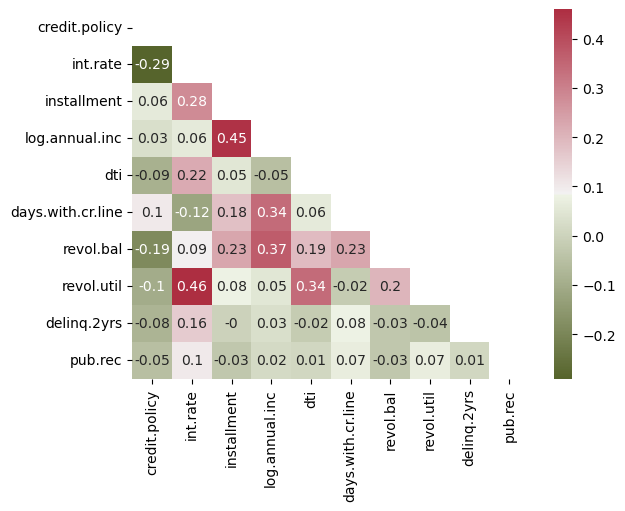

In [36]:
corr_data = df_encoded.loc[:, :'pub.rec'].corr().round(2)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(np.ones_like(corr_data))

# Create a custom divergin palette
cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

# using the upper triangle matrix as mask 
sns.heatmap(corr_data, annot=True, mask=matrix, cmap=cmap);

### Task: Balance the dataset if the data is imbalanced

In [37]:
df_encoded.duplicated().sum() # checking if the processed data has not introduced duplicate values

0

#### Splitting of the dataset

In [38]:
df_encoded.columns

Index(['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti',
       'days.with.cr.line', 'revol.bal', 'revol.util', 'delinq.2yrs',
       'pub.rec', 'not.fully.paid', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_major_purchase',
       'purpose_small_business'],
      dtype='object')

In [39]:
column_to_move = df_encoded.pop('not.fully.paid')

In [40]:
df_encoded.insert(df_encoded.shape[1], "not.fully.paid", column_to_move)
df_encoded.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,days.with.cr.line,revol.bal,revol.util,delinq.2yrs,pub.rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,not.fully.paid
0,1,0.1189,829.10,11.350407,19.48,5639.958333,28854,52.1,0,0,0,1,0,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,2760.000000,33623,76.7,0,0,1,0,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,4710.000000,3511,25.6,0,0,0,1,0,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,2699.958333,33667,73.2,0,0,0,1,0,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,4066.000000,4740,39.5,1,0,1,0,0,0,0,0,0


In [41]:
df_encoded.shape

(9578, 17)

In [44]:
X_cols = df_encoded.columns[:-1] # Storing feature names in a variable
print(X_cols)

Index(['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti',
       'days.with.cr.line', 'revol.bal', 'revol.util', 'delinq.2yrs',
       'pub.rec', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement',
       'purpose_major_purchase', 'purpose_small_business'],
      dtype='object')


In [45]:
#### Spitting

In [46]:
# Splitting the dataset into X and y

X = df_encoded.drop('not.fully.paid', axis = 1).values
y = df_encoded['not.fully.paid'].values

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [51]:
X_train.shape, y_train.shape # checking shape of training data

((7183, 16), (7183,))

In [52]:
X_test.shape, y_test.shape # checking shape of test data

((2395, 16), (2395,))

In [53]:
# Getting training data classes distribution as series

train_target_dist = pd.Series(Counter(y_train))
train_target_dist

0    6016
1    1167
dtype: int64

In [54]:
# Getting test data classes distribution as series

test_target_dist = pd.Series(Counter(y_test))
test_target_dist

0    2029
1     366
dtype: int64

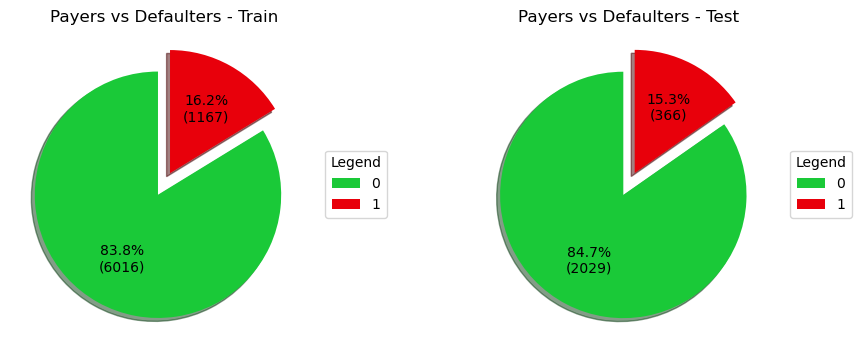

In [57]:
# plotting the pie charts to represent the distribution of target classes across training and test dataset

fig, (ax1, ax2) = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=[11,4])

labels_1 = train_target_dist.index
data_1 = train_target_dist.values
title_1 = "Payers vs Defaulters - Train"

labels_2 = test_target_dist.index
data_2 = test_target_dist.values
title_2 = "Payers vs Defaulters - Test"

colors = sns.color_palette('bright')[2:4]

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

wedges_1, texts_1, autopcts_1 = ax1.pie(x= data_1, 
                                         autopct=lambda pct: func(pct, data_1), 
                                         explode=[0.1]*len(data_1), 
                                         shadow=True, 
                                         startangle = 90,
                                         colors = colors
                                         )

wedges_2, texts_2, autopcts_2 = ax2.pie(x= data_2, 
                                         autopct=lambda pct: func(pct, data_2), 
                                         explode=[0.1]*len(data_2), 
                                         shadow=True, 
                                         startangle = 90,
                                         colors = colors
                                         )

# Adding legend
ax1.legend(wedges_1, labels_1,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

ax2.legend(wedges_2, labels_2,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':9})

ax1.set_title(title_1, fontsize=12)
ax2.set_title(title_2, fontsize=12)
plt.show()

#### Balancing the dataset using Oversampling (RandomOverSampler)

In [151]:
oversampler = RandomOverSampler(sampling_strategy = 0.6, random_state=423)

X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train,y_train)

print(f"The number of classes before fit {Counter(y_train)}")
print(f"The number of classes after fit {Counter(y_train_oversampled)}")

The number of classes before fit Counter({0: 6016, 1: 1167})
The number of classes after fit Counter({0: 6016, 1: 3609})


In [130]:
X_train.shape, y_train.shape

((7183, 16), (7183,))

In [108]:
X_train_oversampled.shape, y_train_oversampled.shape

((10227, 16), (10227,))

In [109]:
before_oversampling_train_target = pd.Series(Counter(y_train))
after_oversampling_train_target = pd.Series(Counter(y_train_oversampled))

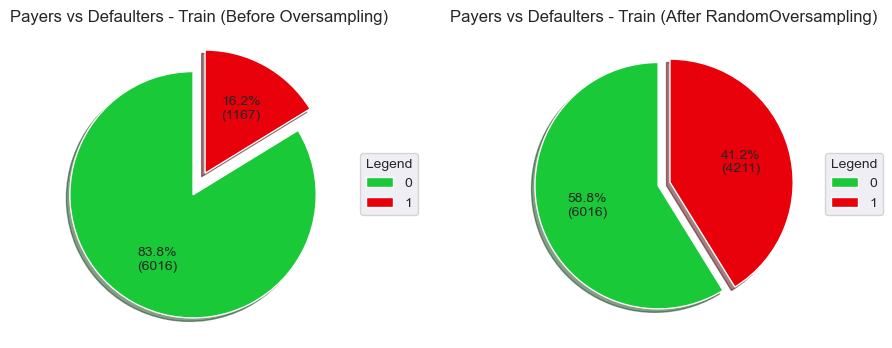

In [131]:
# Plotting the target classes distribution before and after oversampling (Balancing)

fig, (ax1, ax2) = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=[11,4])

labels_1 = before_oversampling_train_target.index
data_1 = before_oversampling_train_target.values
title_1 = "Payers vs Defaulters - Train (Before Oversampling)"

labels_2 = after_oversampling_train_target.index
data_2 = after_oversampling_train_target.values
title_2 = "Payers vs Defaulters - Train (After RandomOversampling)"

colors = sns.color_palette('bright')[2:4]

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

wedges_1, texts_1, autopcts_1 = ax1.pie(x= data_1, 
                                         autopct=lambda pct: func(pct, data_1), 
                                         explode=[0.1]*len(data_1), 
                                         shadow=True, 
                                         startangle = 90,
                                         colors = colors
                                         )

wedges_2, texts_2, autopcts_2 = ax2.pie(x= data_2, 
                                         autopct=lambda pct: func(pct, data_2), 
                                         explode=[0.05]*len(data_2), 
                                         shadow=True, 
                                         startangle = 90,
                                         colors = colors
                                         )

# Adding legend
ax1.legend(wedges_1, labels_1,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

ax2.legend(wedges_2, labels_2,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':9})

ax1.set_title(title_1, fontsize=12)
ax2.set_title(title_2, fontsize=12)
plt.show()

#### Building the ANN Model

In [66]:
scaler = MinMaxScaler()

X_train_original = scaler.fit_transform(X_train)
X_test_original = scaler.transform(X_test)

In [152]:
scaler_random_oversampling = MinMaxScaler()

X_train_oversampled = scaler_random_oversampling.fit_transform(X_train_oversampled)

In [112]:
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')
y_train_oversampled = y_train_oversampled.astype('int64')

In [81]:
# Initialising the ANN
classifier_original = Sequential()

# Adding the input layer and the first hidden layer
classifier_original.add(Dense(16, kernel_initializer = 'he_uniform',activation='relu',input_dim = 16))

# Adding the second hidden layer
classifier_original.add(Dense(8, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the output layer
classifier_original.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier_original.compile(optimizer = 'Adam', 
                                      loss = 'binary_crossentropy', 
                                      metrics = ['accuracy', tf.keras.metrics.Recall(thresholds=0)])

In [82]:
# Fitting the ANN to the Training set
model_history_original = classifier_original.fit(x = X_train_original, 
                                                 y = y_train, 
                                                 validation_split=0.25, 
                                                 batch_size = 1000, 
                                                 epochs = 300)

Epoch 1/300
6/6 [==============================] - 4s 187ms/step - loss: 0.6563 - accuracy: 0.6376 - recall_3: 1.0000 - val_loss: 0.6295 - val_accuracy: 0.7344 - val_recall_3: 1.0000
Epoch 2/300
6/6 [==============================] - 0s 27ms/step - loss: 0.6129 - accuracy: 0.7685 - recall_3: 1.0000 - val_loss: 0.5891 - val_accuracy: 0.8012 - val_recall_3: 1.0000
Epoch 3/300
6/6 [==============================] - 0s 29ms/step - loss: 0.5737 - accuracy: 0.8201 - recall_3: 1.0000 - val_loss: 0.5524 - val_accuracy: 0.8241 - val_recall_3: 1.0000
Epoch 4/300
6/6 [==============================] - 0s 37ms/step - loss: 0.5379 - accuracy: 0.8333 - recall_3: 1.0000 - val_loss: 0.5203 - val_accuracy: 0.8318 - val_recall_3: 1.0000
Epoch 5/300
6/6 [==============================] - 0s 30ms/step - loss: 0.5074 - accuracy: 0.8374 - recall_3: 1.0000 - val_loss: 0.4944 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 6/300
6/6 [==============================] - 0s 26ms/step - loss: 0.4839 - accuracy

Epoch 46/300
6/6 [==============================] - 0s 46ms/step - loss: 0.4253 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4287 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 47/300
6/6 [==============================] - 0s 34ms/step - loss: 0.4250 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4285 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 48/300
6/6 [==============================] - 0s 39ms/step - loss: 0.4247 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4282 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 49/300
6/6 [==============================] - 0s 39ms/step - loss: 0.4245 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4280 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 50/300
6/6 [==============================] - 0s 31ms/step - loss: 0.4242 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4278 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 51/300
6/6 [==============================] - 0s 22ms/step - loss: 0.4239 - acc

Epoch 91/300
6/6 [==============================] - 0s 31ms/step - loss: 0.4174 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4231 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 92/300
6/6 [==============================] - 0s 27ms/step - loss: 0.4173 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4230 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 93/300
6/6 [==============================] - 0s 28ms/step - loss: 0.4172 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4230 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 94/300
6/6 [==============================] - 0s 30ms/step - loss: 0.4171 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4229 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 95/300
6/6 [==============================] - 0s 22ms/step - loss: 0.4170 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4229 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 96/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4169 - acc

6/6 [==============================] - 0s 50ms/step - loss: 0.4140 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4221 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 136/300
6/6 [==============================] - 0s 36ms/step - loss: 0.4139 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4221 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 137/300
6/6 [==============================] - 0s 36ms/step - loss: 0.4139 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4221 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 138/300
6/6 [==============================] - 0s 67ms/step - loss: 0.4138 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4221 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 139/300
6/6 [==============================] - 0s 28ms/step - loss: 0.4137 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4221 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 140/300
6/6 [==============================] - 0s 41ms/step - loss: 0.4137 - accuracy: 0

6/6 [==============================] - 0s 37ms/step - loss: 0.4118 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4217 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 180/300
6/6 [==============================] - 0s 34ms/step - loss: 0.4118 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4218 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 181/300
6/6 [==============================] - 0s 24ms/step - loss: 0.4117 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4217 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 182/300
6/6 [==============================] - 0s 32ms/step - loss: 0.4117 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4217 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 183/300
6/6 [==============================] - 0s 22ms/step - loss: 0.4116 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4218 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 184/300
6/6 [==============================] - 0s 25ms/step - loss: 0.4116 - accuracy: 0

6/6 [==============================] - 0s 35ms/step - loss: 0.4103 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4217 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 224/300
6/6 [==============================] - 0s 30ms/step - loss: 0.4103 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4217 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 225/300
6/6 [==============================] - 0s 39ms/step - loss: 0.4103 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4218 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 226/300
6/6 [==============================] - 0s 31ms/step - loss: 0.4103 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4218 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 227/300
6/6 [==============================] - 0s 39ms/step - loss: 0.4102 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4218 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 228/300
6/6 [==============================] - 0s 29ms/step - loss: 0.4101 - accuracy: 0

6/6 [==============================] - 0s 40ms/step - loss: 0.4090 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4221 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 268/300
6/6 [==============================] - 0s 23ms/step - loss: 0.4090 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4221 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 269/300
6/6 [==============================] - 0s 24ms/step - loss: 0.4090 - accuracy: 0.8387 - recall_3: 1.0000 - val_loss: 0.4221 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 270/300
6/6 [==============================] - 0s 30ms/step - loss: 0.4090 - accuracy: 0.8387 - recall_3: 1.0000 - val_loss: 0.4222 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 271/300
6/6 [==============================] - 0s 27ms/step - loss: 0.4089 - accuracy: 0.8385 - recall_3: 1.0000 - val_loss: 0.4222 - val_accuracy: 0.8346 - val_recall_3: 1.0000
Epoch 272/300
6/6 [==============================] - 0s 23ms/step - loss: 0.4089 - accuracy: 0

In [83]:
losses_original = pd.DataFrame(classifier_original.history.history)
losses_original.head()

,loss,accuracy,recall_3,val_loss,val_accuracy,val_recall_3
0,0.656324,0.637646,1.0,0.629524,0.734410,1.0
1,0.612927,0.768517,1.0,0.589092,0.801225,1.0
2,0.573669,0.820123,1.0,0.552369,0.824053,1.0
3,0.537928,0.833302,1.0,0.520304,0.831849,1.0
4,0.507357,0.837386,1.0,0.494437,0.834633,1.0


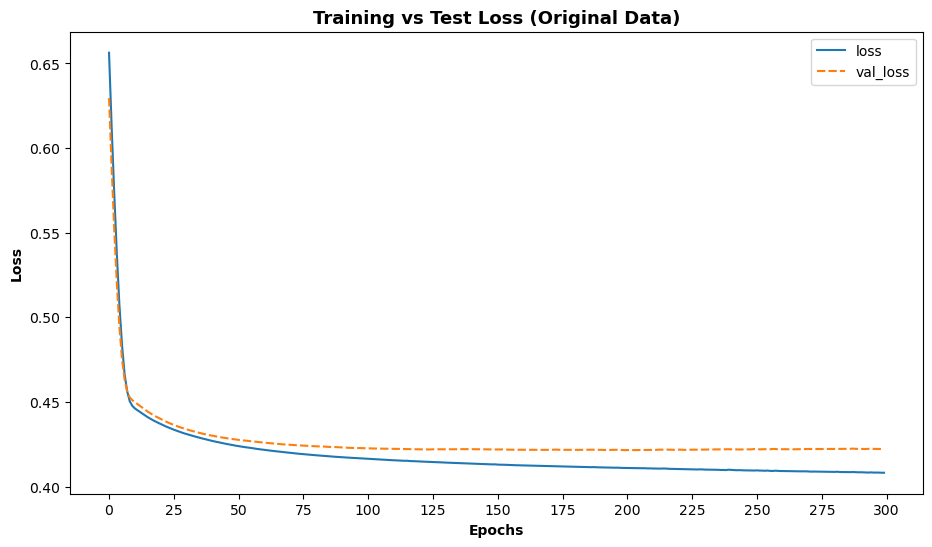

In [84]:
plt.figure(figsize=(11,6))
sns.lineplot(data = losses_original[['loss', 'val_loss']])
plt.title('Training vs Test Loss (Original Data)', fontsize = 13, fontweight="bold")
plt.xlabel('Epochs', fontweight="bold")
plt.ylabel('Loss', fontweight="bold")

plt.xticks(range(0, 301, 25))

plt.show()


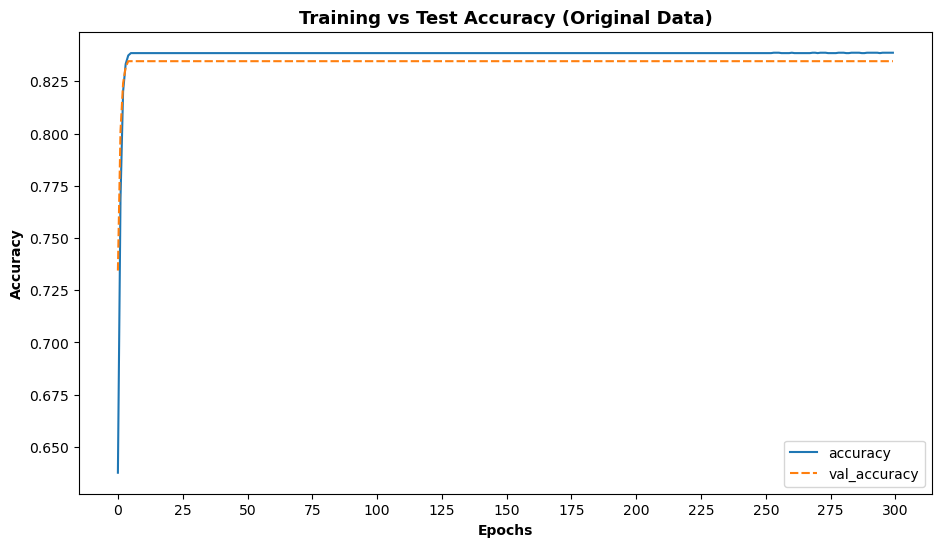

In [85]:
plt.figure(figsize=(11,6))
sns.lineplot(data = losses_original[['accuracy', 'val_accuracy']])
plt.title('Training vs Test Accuracy (Original Data)', fontsize = 13, fontweight="bold")
plt.xlabel('Epochs', fontweight="bold")
plt.ylabel('Accuracy', fontweight="bold")

plt.xticks(range(0, 301, 25))

plt.show()

In [87]:
losses_original.iloc[50:51,:]

,loss,accuracy,recall_3,val_loss,val_accuracy,val_recall_3
50,0.423919,0.8385,1.0,0.42762,0.834633,1.0


In [86]:
classifier_original = Sequential()

classifier_original.add(Dense(16, kernel_initializer = 'he_uniform',activation='relu',input_dim = 16))
classifier_original.add(Dense(8, kernel_initializer = 'he_uniform',activation='relu'))
classifier_original.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))


classifier_original.compile(optimizer = 'Adam', 
                                      loss = 'binary_crossentropy', 
                                      metrics = ['accuracy', tf.keras.metrics.Recall(thresholds=0)])


model_history_original = classifier_original.fit(x = X_train_original, 
                                                 y = y_train, 
                                                 validation_split=0.25, 
                                                 batch_size = 1000, 
                                                 epochs = 50, verbose=0)

In [88]:
y_pred_train = classifier_original.predict(X_train_original)
y_pred_train = np.where(y_pred_train > 0.45, 1,0)


y_pred_test = classifier_original.predict(X_test_original)
y_pred_test = np.where(y_pred_test > 0.45, 1,0)

75/75 [==============================] - 0s 4ms/step


In [89]:
np.unique(y_pred_train, return_counts=True)

(array([0, 1]), array([7143,   40], dtype=int64))

In [90]:
np.unique(y_pred_test, return_counts=True)

(array([0, 1]), array([2377,   18], dtype=int64))



************************** Confusion Matrix (Training Data) **************************




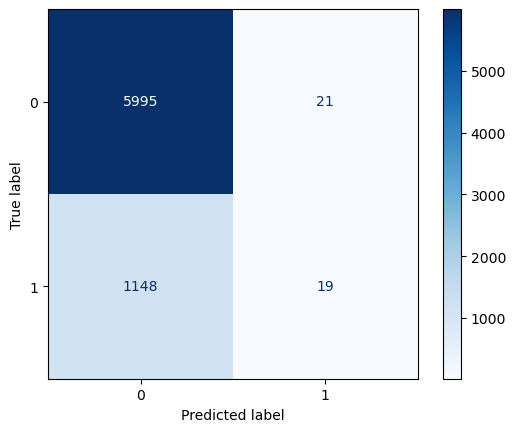

In [91]:
print("\n\n************************** Confusion Matrix (Training Data) **************************\n\n")

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='')
plt.show()


In [92]:
print("\n\n************************** Classification Report (Train Data) **************************\n\n")
print(classification_report(y_train, y_pred_train))



************************** Classification Report (Train Data) **************************


              precision    recall  f1-score   support

           0       0.84      1.00      0.91      6016
           1       0.47      0.02      0.03      1167

    accuracy                           0.84      7183
   macro avg       0.66      0.51      0.47      7183
weighted avg       0.78      0.84      0.77      7183





************************** Confusion Matrix (Test Data) **************************



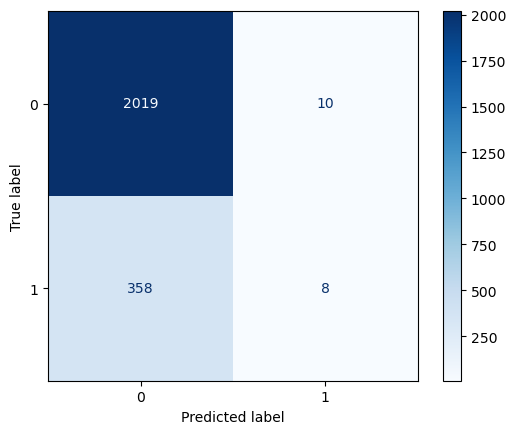

In [93]:
print("\n\n************************** Confusion Matrix (Test Data) **************************\n")

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='')
plt.show()

In [94]:
print("\n\n************************** Classification Report (Test Data) **************************\n\n")
print(classification_report(y_test, y_pred_test))



************************** Classification Report (Test Data) **************************


              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2029
           1       0.44      0.02      0.04       366

    accuracy                           0.85      2395
   macro avg       0.65      0.51      0.48      2395
weighted avg       0.79      0.85      0.78      2395



75/75 [==============================] - 0s 4ms/step


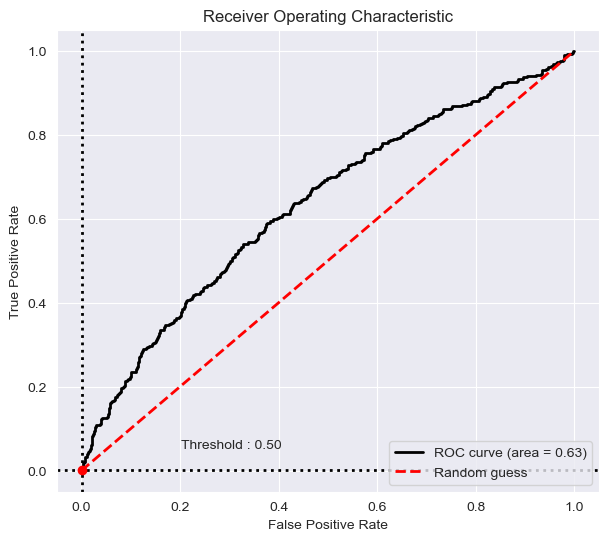

In [95]:
# plotting ROC Curve

# Getting predicted probabilites values, for plotting of ROC curve
test_pred_probs = classifier_original.predict(X_test_original)

# Visualisation with plot_metric
bc = BinaryClassification(y_test, test_pred_probs, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(7,6))
bc.plot_roc_curve()
plt.show()

#### Oversampled Model

In [155]:
# Initialising the ANN 
classifier_random_oversampled = Sequential()

# Adding the input layer and the first hidden layer
classifier_random_oversampled.add(Dense(8, kernel_initializer = 'he_uniform',activation='relu',input_dim = 16))

# Adding the second hidden layer
classifier_random_oversampled.add(Dense(4, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the third hidden layer
#classifier_random_oversampled.add(Dense(4, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the output layer
classifier_random_oversampled.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier_random_oversampled.compile(optimizer = 'Adamax', 
                                      loss = 'binary_crossentropy', 
                                      metrics = ['accuracy', tf.keras.metrics.Recall(thresholds=0)])

In [156]:
# Fitting the ANN to the Training set
model_history_original = classifier_random_oversampled.fit(x = X_train_oversampled, 
                                                             y = y_train_oversampled, 
                                                             validation_split=0.35, 
                                                             batch_size = 2000, 
                                                             epochs = 300)

Epoch 1/300
4/4 [==============================] - 3s 327ms/step - loss: 0.7324 - accuracy: 0.1766 - recall_17: 1.0000 - val_loss: 0.6620 - val_accuracy: 0.7688 - val_recall_17: 1.0000
Epoch 2/300
4/4 [==============================] - 0s 61ms/step - loss: 0.7254 - accuracy: 0.1829 - recall_17: 1.0000 - val_loss: 0.6662 - val_accuracy: 0.7605 - val_recall_17: 1.0000
Epoch 3/300
4/4 [==============================] - 0s 37ms/step - loss: 0.7192 - accuracy: 0.1974 - recall_17: 1.0000 - val_loss: 0.6701 - val_accuracy: 0.7400 - val_recall_17: 1.0000
Epoch 4/300
4/4 [==============================] - 0s 39ms/step - loss: 0.7135 - accuracy: 0.2271 - recall_17: 1.0000 - val_loss: 0.6739 - val_accuracy: 0.6955 - val_recall_17: 1.0000
Epoch 5/300
4/4 [==============================] - 0s 41ms/step - loss: 0.7082 - accuracy: 0.2805 - recall_17: 1.0000 - val_loss: 0.6775 - val_accuracy: 0.6284 - val_recall_17: 1.0000
Epoch 6/300
4/4 [==============================] - 0s 37ms/step - loss: 0.7033 

4/4 [==============================] - 0s 54ms/step - loss: 0.5297 - accuracy: 0.8382 - recall_17: 1.0000 - val_loss: 0.9637 - val_accuracy: 0.2303 - val_recall_17: 1.0000
Epoch 46/300
4/4 [==============================] - 0s 61ms/step - loss: 0.5260 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 0.9797 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 47/300
4/4 [==============================] - 0s 38ms/step - loss: 0.5221 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 0.9968 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 48/300
4/4 [==============================] - 0s 32ms/step - loss: 0.5178 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.0153 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 49/300
4/4 [==============================] - 0s 43ms/step - loss: 0.5128 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.0355 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 50/300
4/4 [==============================] - 0s 59ms/step - loss: 0.5070 - accura

4/4 [==============================] - 0s 49ms/step - loss: 0.4388 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.4206 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 90/300
4/4 [==============================] - 0s 35ms/step - loss: 0.4386 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.4200 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 91/300
4/4 [==============================] - 0s 33ms/step - loss: 0.4384 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.4190 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 92/300
4/4 [==============================] - 0s 34ms/step - loss: 0.4381 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.4174 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 93/300
4/4 [==============================] - 0s 32ms/step - loss: 0.4379 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.4169 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 94/300
4/4 [==============================] - 0s 38ms/step - loss: 0.4377 - accura

4/4 [==============================] - 0s 36ms/step - loss: 0.4307 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3913 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 134/300
4/4 [==============================] - 0s 46ms/step - loss: 0.4306 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3906 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 135/300
4/4 [==============================] - 0s 42ms/step - loss: 0.4305 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3909 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 136/300
4/4 [==============================] - 0s 37ms/step - loss: 0.4303 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3917 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 137/300
4/4 [==============================] - 0s 42ms/step - loss: 0.4302 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3914 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 138/300
4/4 [==============================] - 0s 32ms/step - loss: 0.4301 - a

4/4 [==============================] - 0s 52ms/step - loss: 0.4260 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3688 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 178/300
4/4 [==============================] - 0s 38ms/step - loss: 0.4259 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3697 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 179/300
4/4 [==============================] - 0s 42ms/step - loss: 0.4259 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3717 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 180/300
4/4 [==============================] - 0s 32ms/step - loss: 0.4258 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3717 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 181/300
4/4 [==============================] - 0s 38ms/step - loss: 0.4257 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3722 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 182/300
4/4 [==============================] - 0s 53ms/step - loss: 0.4256 - a

4/4 [==============================] - 0s 49ms/step - loss: 0.4228 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3518 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 222/300
4/4 [==============================] - 0s 44ms/step - loss: 0.4228 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3497 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 223/300
4/4 [==============================] - 0s 42ms/step - loss: 0.4227 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3485 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 224/300
4/4 [==============================] - 0s 51ms/step - loss: 0.4226 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3474 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 225/300
4/4 [==============================] - 0s 53ms/step - loss: 0.4226 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3470 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 226/300
4/4 [==============================] - 0s 53ms/step - loss: 0.4225 - a

4/4 [==============================] - 0s 67ms/step - loss: 0.4208 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3457 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 266/300
4/4 [==============================] - 0s 49ms/step - loss: 0.4208 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3500 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 267/300
4/4 [==============================] - 0s 59ms/step - loss: 0.4208 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3545 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 268/300
4/4 [==============================] - 0s 54ms/step - loss: 0.4208 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3578 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 269/300
4/4 [==============================] - 0s 50ms/step - loss: 0.4208 - accuracy: 0.8381 - recall_17: 1.0000 - val_loss: 1.3600 - val_accuracy: 0.2294 - val_recall_17: 1.0000
Epoch 270/300
4/4 [==============================] - 0s 61ms/step - loss: 0.4207 - a

In [157]:
losses_random = pd.DataFrame(classifier_random_oversampled.history.history)
losses_random.head()

,loss,accuracy,recall_17,val_loss,val_accuracy,val_recall_17
0,0.732374,0.176630,1.0,0.662033,0.768774,1.0
1,0.725411,0.182864,1.0,0.666168,0.760463,1.0
2,0.719191,0.197410,1.0,0.670114,0.739982,1.0
3,0.713496,0.227142,1.0,0.673880,0.695459,1.0
4,0.708185,0.280531,1.0,0.677493,0.628376,1.0


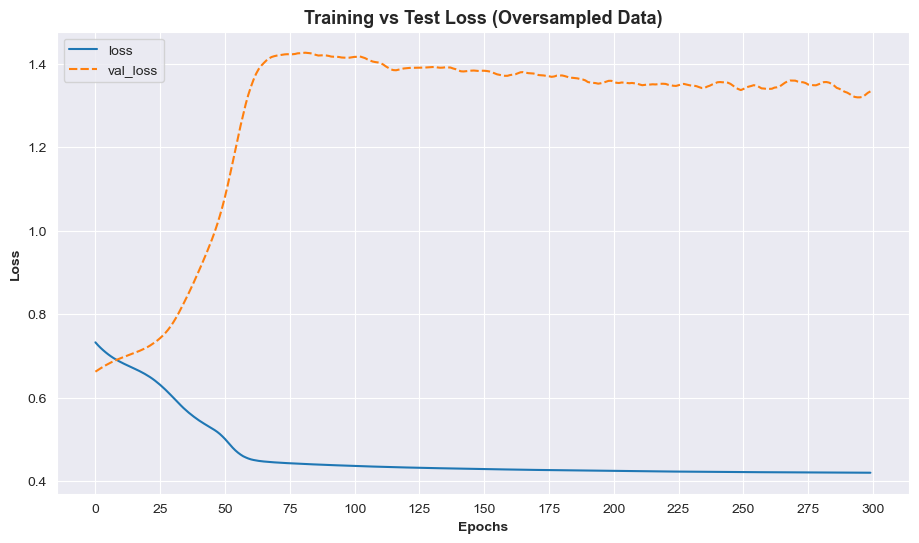

In [158]:
plt.figure(figsize=(11,6))
sns.lineplot(data = losses_random[['loss', 'val_loss']])
plt.title('Training vs Test Loss (Oversampled Data)', fontsize = 13, fontweight="bold")
plt.xlabel('Epochs', fontweight="bold")
plt.ylabel('Loss', fontweight="bold")

plt.xticks(range(0, 301, 25))

plt.show()

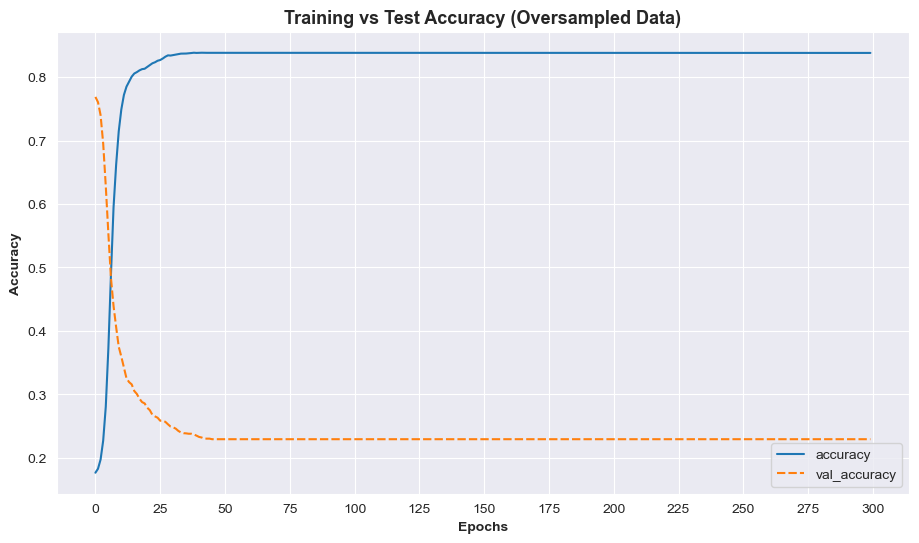

In [159]:
plt.figure(figsize=(11,6))
sns.lineplot(data = losses_random[['accuracy', 'val_accuracy']])
plt.title('Training vs Test Accuracy (Oversampled Data)', fontsize = 13, fontweight="bold")
plt.xlabel('Epochs', fontweight="bold")
plt.ylabel('Accuracy', fontweight="bold")

plt.xticks(range(0, 301, 25))

plt.show()